##### Copyright 2019 The TensorFlow Authors.

##### Modifications Copyright 2019 Tomoaki Masuda.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

このノートブックは、以下のノートブックを元に日本語訳、一部章立ての再構成、加筆を行いました。https://github.com/tensorflow/docs/blob/master/site/en/r2/tutorials/images/transfer_learning.ipynb


# 事前学習済みCNN(MobileNet V2)を使った転移学習



このチュートリアルでは、事前学習済みモデルと、その転移学習（ファインチューニング）を使って、犬猫画像の分類を試します。 

 **事前学習済みモデル**は、通常大規模なデータセット・画像分類タスクで予め学習、保存されたニューラルネットワークです。事前学習済みモデルは、そのまま使うか、または、**転送学習**で特定のタスク用にカスタマイズして使います。

転移学習は、直感的に説明すると、大規模かつ十分に汎用的なデータセットで学習したモデルは視覚（画像）に汎用的に使えるので、それをベースに使い各タスク向けのカスタマイズを行うやり方です。これにより、大規模なデータセット・モデルで一から学習せずとも、これらの学習済みモデルが抽出する特徴マップ(feature map)を使えます。

このノートブックでは、学習済みモデルをカスタマイズして使う2つの方法を試します。 

1.  **学習済みモデルを特徴抽出に使う** ：新規画像から意味のある特徴を抽出するため、既にモデルにより学習済みの表現を使う。事前に学習済みのモデルの上に、最初から学習した新しい分類器を追加するだけで、以前に学習した特徴マップを、新しいデータセット用に再利用できます。このとき、モデル全体を（再）学習しなくて済みます。CNNのベース部分には、画像分類に一般的に役立つ機能がすでに含まれています。ただし、事前トレーニング済みモデルの最後の分類部分は、元の分類タスクに固有のものであり、その後モデルが学習されたクラスのセットに固有のものです。 

2.  **学習済みモデルのファインチューニング** ：重みが固定されたモデルベースの最上位レイヤのいくつかを、再度重みを動かせる状態にし、新しく追加された分類レイヤとベースモデルの最終レイヤの両方を学習します。これにより、ベースモデル内の高次の特徴表現を、対象とするタスクにより使いやすくするため「微調整」できます。 

ここからは、一般的な機械学習の流れに従って進めます。

1. データセットの中身を見て、理解する
1. 入力パイプラインを作る（今回はKeras `ImageDataGenerator`を使います）
1. モデルを作る
  * 事前学習済みモデル（および学習済みの重み）を読み込む
  * 分類のためのレイヤを上に積む
1. モデルを学習させる
1. モデルを評価する


## A. 環境を準備する

必要なライブラリのインストール、インポートを行います。ここではTensorFlow 2.2を使います。

In [3]:
import os

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

# Check libraries version
print(f'TensorFlow Version: {tf.__version__}')
print(f'tf.keras Version: {keras.__version__}')

TensorFlow Version: 2.1.0
tf.keras Version: 2.2.4-tf



## B. データセットを準備する



### 1. データセットをインポートする


[TensorFlowデータセット](http://tensorflow.org/datasets)を使って、猫と犬のデータセットを読み込みます。 

`tfds`パッケージを使うと、とても簡単に、予め準備されたデータセットを読み込めます。あなた自身の持っているデータセットを使い、TensroFlowでインポートしたい場合は、[画像データのロード](../load_data/images.ipynb)ノートブックをご参照ください。

In [4]:
try:
  import tensorflow_datasets as tfds
except:
  # The tensorflow-datasets module is an external module, so if you don't have it in your environment, you need to pip install it.
  !python -m pip install tensorflow-datasets
  import tensorflow_datasets as tfds
tfds.disable_progress_bar()


 `tfds.load()`関数はデータセットをダウンロードしてキャッシュし、 `tf.data.Dataset`オブジェクトを返します。このオブジェクトは、データを操作し、モデルに入力するため、強力かつ効率的な方法を提供します。

 `"cats_vs_dog"`はデータセットの分割方法を予め定義していません。 `subsplit()`関数を使って、学習、検証、テストデータセットをそれをそれぞれ80％、10％、10％に分けることにします。


In [5]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)


結果として返される `tf.data.Dataset`オブジェクトは、`(image, label)`ペアを持ちます。 

- `画像(image)` は縦横のサイズは可変、各ピクセルは3つのチャンネル（RGB（赤緑青）に対応する3つの数値）を持ちます。
- `ラベル(label)` は、対応する画像ごとに、スカラー値を1つ取ります。


In [6]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


### 2. データセットの中身を見てみる


トレーニングセットの最初の2つの画像とラベルを表示します。 


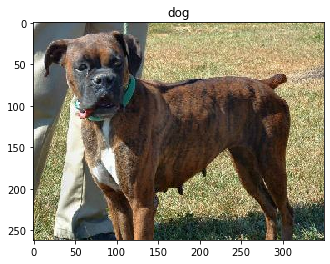

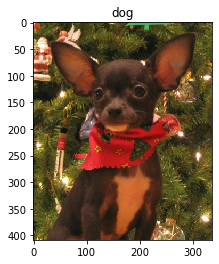

In [7]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))


### C. データセットを前処理する

画像に前処理を施すために `tf.image`モジュールを使います。 

画像を、予め決められた入力サイズ（160x160）に合わせてサイズ変更し、各ピクセルのチャンネル（もともとは0から255の間）を、`[-1,1]`の範囲におさまるように変換します。


In [8]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label


 `map()` 関数を使って、データセットの各項目にこの関数を適用します。 


In [9]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)


データセットをシャッフルして、バッチにまとめます。


In [10]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [11]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)


データセットのバッチを調べます。（1ピクセルにつきRGB3種類の数値を持つ、160x160の画像が、32個束ねられたバッチが作られています）


In [12]:
for image_batch, label_batch in train_batches.take(1):
  pass

image_batch.shape

TensorShape([32, 160, 160, 3])

# その1 - 学習済みモデルを特徴抽出に使う


## D. モデルを作成する

### 1. 学習済みモデルからベースモデルを作る

 Googleが開発した**MobileNet V2**から、ベースとなるモデルを作ります。このモデルは、ImageNet（1.4M画像と1000クラスのWeb画像からなる大規模データセット）で事前学習されています。 ImageNetは研究用の学習データセットです。 `jackfruit（ジャックフルーツ）`や`syringe（注射器）`などのカテゴリを含むなど偏りがないとも言えません。しかし、この知識ベースは、我々のデータセットで犬猫分類をするのに役立ちます。 

まず、MobileNet V2のどの層を特徴抽出に使うか選びます。明らかに、最後の分類レイヤ（または「一番上」のレイヤ - 機械学習モデルを図示するとき、ほとんどの場合は下から上に層を積み上げるよう描くため）はあまり役に立ちません。代わりに、`Flatten` 操作直前のレイヤを使うという、一般的な方法に従います。この層は「ボトルネック層」と呼ばれます。ボトルネック層の抽出する特徴は、最終層/最上層と比較しても、汎用性が高いといわれます。 

まず、ImageNetで学習済みの重みをロードしたMobileNet V2モデルを呼び出し（インスタンス化し）ます。 **include_top = False**引数を指定すると、一番上の分類レイヤを除いたモデルが読み込まれます。これは、特徴抽出のために使うときに便利です。 


In [13]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')


この特徴抽出は、`160x160x3`の画像から、`5x5x1280`の特徴マップを取り出します。バッチの例を見てみましょう。

In [14]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)



### 2. 学習済みモデルを特徴抽出に使う

前の手順で作成した畳み込みニューラルネットワーク（CNN）のベース部分の重みを固定し、それを特徴抽出に使います。その上に分類器を積み上げ、その分類レイヤを学習させます。



#### 2.1 CNNベース部分の重みを固定する

モデルをコンパイルして学習を始める前に、CNNベース部分の重みを固定することが大事です。それ（凍結する、フリーズするとも呼びます）をすることで（または`layer.trainable = False` と設定する）、学習中に対象レイヤの重みが更新されなくなります。 MobileNet V2には多くのレイヤーがあります。モデル全体のtrainableフラグを`False`設定すると、全レイヤーの重みが更新されなくなります。 


In [15]:
base_model.trainable = False

In [16]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________


#### 2.2 分類ヘッドを追加する



特徴ブロックから予測を生成するため、 `tf.keras.layers.GlobalAveragePlloing2d`レイヤを使って、 `5x5`ごとに平均化とプーリングを行い、特徴を1画像あたり1280要素を持つ1次元ベクトルに変換します。

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)



これらの特徴を、 `tf.keras.layers.Dense`レイヤを通して、画像ごとに単一の予測に変換します。この予測は`logit`または生の予測値として扱われるため、ここでは活性化関数は使いません。正は `class 1`、負は `class 0` を予測します。 


In [18]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)



そして、`tf.keras.Sequential` を使って、特徴抽出部分とこれら2つのレイヤーを連結・積み上げます。


In [19]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])


### 3. モデルをコンパイルする

訓練する前にモデルをコンパイルする必要があります。 2クラス分類のため、バイナリクロスエントロピー損失を使います。


In [20]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________



 MobileNetの2.5Mパラメータは固定されました。ただし、まだDenseレイヤには1.2Kの*学習可能*なパラメータがあります。これらは2つの`tf.Variable`オブジェクト、重みとバイアスに分けられます。 


In [22]:
len(model.trainable_variables)

2


## E. モデルを学習させる

 10エポックで、〜96％程度の精度まで学習が進みます。


In [23]:
initial_epochs = 10
validation_steps = 20
loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 2s 111ms/step - loss: 3.2594 - accuracy: 0.6375


In [24]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.26
initial accuracy: 0.64


In [25]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 35s 60ms/step - loss: 2.7186 - accuracy: 0.6804 - val_loss: 1.6800 - val_accuracy: 0.8014
Epoch 2/10
582/582 [==============================] - 31s 53ms/step - loss: 1.2786 - accuracy: 0.8325 - val_loss: 0.9448 - val_accuracy: 0.8865
Epoch 3/10
582/582 [==============================] - 29s 51ms/step - loss: 0.8671 - accuracy: 0.8856 - val_loss: 0.8832 - val_accuracy: 0.9003
Epoch 4/10
582/582 [==============================] - 29s 50ms/step - loss: 0.7128 - accuracy: 0.9077 - val_loss: 0.6535 - val_accuracy: 0.9235
Epoch 5/10
582/582 [==============================] - 32s 55ms/step - loss: 0.6385 - accuracy: 0.9160 - val_loss: 0.5604 - val_accuracy: 0.9325
Epoch 6/10
582/582 [==============================] - 29s 50ms/step - loss: 0.5942 - accuracy: 0.9237 - val_loss: 0.6278 - val_accuracy: 0.9239
Epoch 7/10
582/582 [==============================] - 30s 51ms/step - loss: 0.5741 - accuracy: 0.9276 - val_loss: 0.5140 - val_accuracy:


### 1. 学習曲線を確認する

 MobileNet V2基本モデルを固定の特徴抽出器として使った場合の、学習曲線と検証の精度/損失を見てみましょう。 


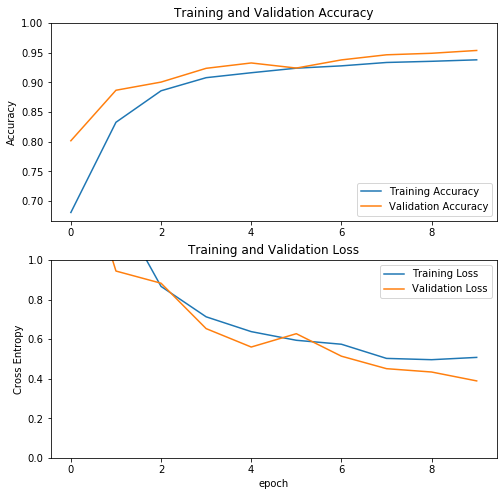

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


注：検証時の精度・損失（メトリクス）が学習時の精度・損失より明らかに優れている理由の一つは、 `tf.keras.layers.BatchNormalization` や`tf.keras.layers.Dropout` などのレイヤが学習中の精度に影響を与えるためです。これらは、検証損失の計算時は使われません。 

上記ほどではないものの、学習時の精度・損失はエポックの平均を報告し、検証時はエポックの後に評価されるため、検証時の精度・損失は、学習時よりもやや長く学習しモデルに基づくものです。 


# その2 - 学習済みモデルのファインチューニング


先の `学習済みモデルを特徴抽出に使う` では、MobileNet V2のベースモデル上に数層を学習させるだけでした。事前学習済みモデルの重みは、学習中には**更新されませんでした** 。 

さらに精度を向上させる方法に、追加した分類器のトレーニングと並行し、事前学習済みモデルの最上位層の重みを学習（または「ファインチューニング」）することがあげられます。学習を通して、汎用的な特徴マップから、特に目的のデータセットに関連付けられた特徴抽出のため、重みが調整されます。 

注：この場合もまず先に、事前学習済みモデルを `non-trainable（重みを固定）` に設定し、最上位の分類器を学習します。事前学習済みモデル上に、ランダムに初期化された分類器を追加して全レイヤの学習を同時に始めると、（分類器からのランダムな重みのために）勾配の更新の大きさが大きすぎてしまいます。それにより、せっかく事前学習で得た重みが忘れられて（消し飛んで）しまいます。

また、MobileNetモデル全体ではなく、少数の最上位レイヤをファインチューニング対象とすると良いでしょう。多くの畳み込みネットワークでは、層が上に行くほど、より特化した機能を持ちます。最初の数層は、様々な種類の画像に共通の、単純・汎用的な特徴を学びます。上に行くにつれて、特徴抽出は、モデルが学習に用いたデータセット特有のものになります。ファインチューニングの目的は、学習済みの汎用的な部分を上書きするのではなく、これらのデータセットに特化した特徴抽出を、新しいデータセットで使えるように調整することです。

## D. モデルを作成する


### 1. モデルの最上層を解凍する



あなたがする必要があるのは`base_model`し、最下層を訓練`base_model`することです。次に、モデルを再コンパイルし（これらの変更を有効にするために必要）、トレーニングを再開します。 


In [27]:
base_model.trainable = True

In [28]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155



### 2. モデルをコンパイルする

通常よりかなり小さな学習率を使い、モデルをコンパイルします。 


In [29]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


In [31]:
len(model.trainable_variables)

58


## E. モデルを学習させる



これでより早く学習が収束するようなら、数パーセントの精度向上が見られるかもしれません。


In [32]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches, 
                         epochs=total_epochs, 
                         initial_epoch = initial_epochs,
                         validation_data=validation_batches)

Epoch 11/20
582/582 [==============================] - 35s 61ms/step - loss: 0.4342 - accuracy: 0.9449 - val_loss: 0.2537 - val_accuracy: 0.9742
Epoch 12/20
582/582 [==============================] - 30s 52ms/step - loss: 0.3434 - accuracy: 0.9580 - val_loss: 0.2350 - val_accuracy: 0.9738
Epoch 13/20
582/582 [==============================] - 32s 55ms/step - loss: 0.2753 - accuracy: 0.9663 - val_loss: 0.2410 - val_accuracy: 0.9686
Epoch 14/20
582/582 [==============================] - 29s 50ms/step - loss: 0.2554 - accuracy: 0.9688 - val_loss: 0.2644 - val_accuracy: 0.9708
Epoch 15/20
582/582 [==============================] - 31s 54ms/step - loss: 0.2210 - accuracy: 0.9730 - val_loss: 0.2599 - val_accuracy: 0.9695
Epoch 16/20
582/582 [==============================] - 32s 55ms/step - loss: 0.1953 - accuracy: 0.9775 - val_loss: 0.2773 - val_accuracy: 0.9729
Epoch 17/20
582/582 [==============================] - 33s 56ms/step - loss: 0.1764 - accuracy: 0.9794 - val_loss: 0.2609 - val_ac


 MobileNet V2基本モデルの最後の数層をファインチューニングし、その上で分類器を学習す流場合の、学習と検証の精度/損失の学習曲線を見てみましょう。検証の損失は学習の損失よりはるかに大きいので、一定の過学習が見られるかもしれません。 

また、新しい学習データセットは比較的小さく、元のMobileNet V2データセットと似ているため、過学習の原因となっているかもしれません。


微調整後、モデルはほぼ98％の精度に達します。 


In [33]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

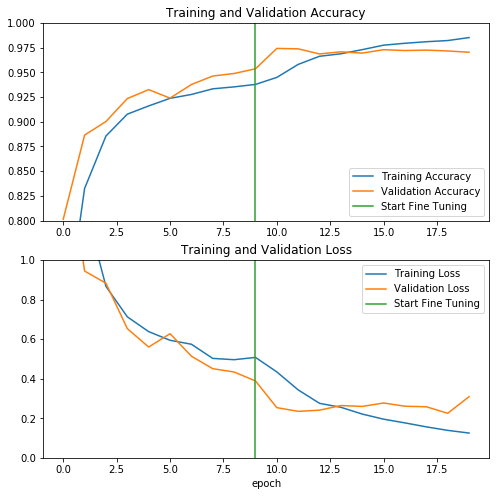

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1], 
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1], 
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


## まとめ 

-  **事前学習モデルを特徴抽出に使う** ：小さなデータセットを扱うときは、同じドメイン内のより大きなデータセットでモデルが学習した特徴を使うのが一般的です。事前学習済みモデルをインスタンス化し、その上に全結合層による分類器レイヤを加え実現します。事前学習モデルは重みを固定（凍結）されており、分類器レイヤの重みのみが更新されます。 この場合、CNNのベース部分は各画像の特徴を抽出し、抽出された特徴から、画像のクラスを決定する分類器を学習しました。 

-  **事前学習済みモデルのファインチューニング** ：パフォーマンス向上のために、事前学習済みモデルの上位層を、ファインチューニングにより新しいデータセットに適応させられます。この場合、モデルがデータセットに固有の高度な特徴を学習する、重みを調整しました。この手法は通常、学習データセットが大きく、事前学習のデータセットとよく似ている場合に推奨されます。 
